<a href="https://colab.research.google.com/github/Aakash-Modi/DL-model-fusion-at-score-level-for-img-classification/blob/main/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import data files
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d zalando-research/fashionmnist
!unzip \*.zip  && rm *.zip

Saving kaggle.json to kaggle.json
 86% 59.0M/68.8M [00:00<00:00, 50.7MB/s]
100% 68.8M/68.8M [00:00<00:00, 78.8MB/s]
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [ ]:
# import libraries
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications import VGG16

from keras.preprocessing.image import img_to_array, array_to_img
from keras import callbacks
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg16
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

'''
import cv2
import random
import itertools
import os
'''
'''
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from keras.layers import Embedding'''

'\nfrom sklearn.metrics import classification_report, confusion_matrix\n\nfrom sklearn.model_selection import train_test_split\nfrom keras.layers import Embedding'

In [ ]:
# read csv data files
traindata = pd.read_csv("fashion-mnist_train.csv")
testdata = pd.read_csv("fashion-mnist_test.csv")

In [ ]:
traindata.shape #(60,000*785)
testdata.shape #(10000,785)
trainX = np.array(traindata.iloc[:,1:])
testX = np.array(testdata.iloc[:,1:])
trainY = np.array (traindata.iloc[:,0]) # (60000,)
testY = np.array(testdata.iloc[:,0]) #(10000,)
tx = trainX
tex = testX

In [ ]:
traindata.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
trainX.shape, testX.shape

((60000, 784), (10000, 784))

***Preparation & preprocessing data***

In [ ]:
# convert images into 3 channels to fit as input for transfer model (VGG16)
trainX=np.dstack([trainX] * 3)
testX=np.dstack([testX]*3)
trainX.shape,testX.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
# reshape images as per the tensor format required by tensorflow
trainX = trainX.reshape(-1, 28,28,3)
testX= testX.reshape (-1,28,28,3)
trainX.shape,testX.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
# resize the images from 28*28 to 48*48 as required for transfer learning 
trainX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in trainX])
testX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in testX])
trainX.shape, testX.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
# labels
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

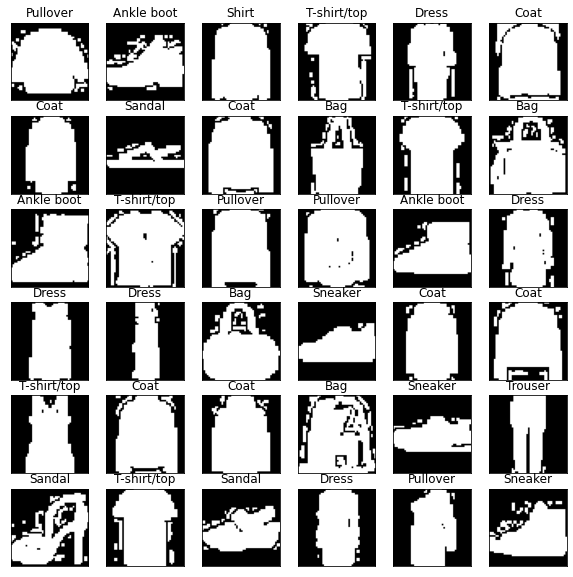

In [ ]:
# visualize some samples
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i])
    label_index = int(trainY[i])
    plt.title(class_name[label_index])
plt.show()

***Data Normalization***

In [ ]:
trainX = trainX / 255
testX = testX / 255

***Convert labels to one-hot encoder***

In [ ]:
trainY_one_hot = to_categorical(trainY)
testY_one_hot = to_categorical(testY)
print(trainY_one_hot)
print(testY_one_hot)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


***Splitting train data into training and validation data***

In [ ]:
trainX, validX, train_label, valid_label = train_test_split(trainX, trainY_one_hot, test_size=0.05, random_state=13)
trainX.shape, validX.shape

((57000, 48, 48, 3), (3000, 48, 48, 3))

***Models***

In [ ]:
imageSize = trainX[0].shape[0]
Channels = 3
print("imageSize : ",imageSize)

imageSize :  48


*Model formation*

*1) Uni-model (transfer learning model VGG16)*

In [ ]:
# import transfer learning model (VGG16)
vgg16 = keras.applications.VGG16(input_shape =(imageSize, imageSize, Channels), include_top = False, weights = 'imagenet')
vgg16.trainable = False

# model definition
inp1 = keras.Input(shape=(imageSize, imageSize, Channels))
x1 = vgg16(inp1, training=False)
x1 = GlobalMaxPool2D()(x1)
x1 = Dense(128, activation='relu')(x1)
out1 = Dense(10,activation="softmax")(x1)

model1 = Model(inp1, out1)
model1.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


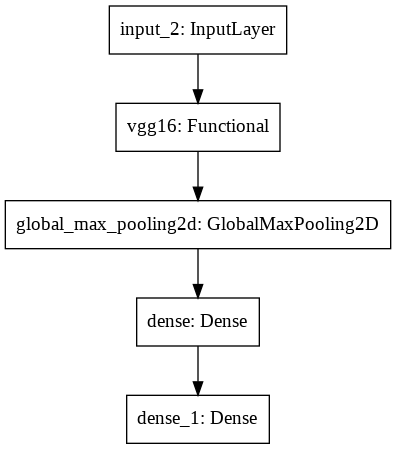

In [ ]:
keras.utils.plot_model(model1, "my_first_model.png")

*2) Uni-model (CNN with 4 layers)*

In [ ]:
# model definition
inp2 = keras.Input(shape=(imageSize, imageSize, Channels))
conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp2)
batch_normalization_1 = BatchNormalization()(conv_1)
conv_2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(batch_normalization_1)
batch_normalization_2 = BatchNormalization()(conv_2)
maxpool_1 = keras.layers.MaxPooling2D((2, 2))(batch_normalization_2)
dropout_1 = keras.layers.Dropout(0.25)(maxpool_1)
conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(dropout_1)
batch_normalization_3 = BatchNormalization()(conv_3)
dropout_2 = keras.layers.Dropout(0.25)(batch_normalization_3)
conv_4 = keras.layers.Conv2D(128, (3, 3), activation='relu')(dropout_2)
batch_normalization_4 = BatchNormalization()(conv_4)
maxpool_2 = keras.layers.MaxPooling2D((2, 2))(batch_normalization_4)
dropout_3 = keras.layers.Dropout(0.25)(maxpool_2)
flatten = keras.layers.Flatten()(dropout_3)
dense_1 = keras.layers.Dense(512, activation='relu')(flatten)
batch_normalization_5 = BatchNormalization()(dense_1)
dropout_4 = keras.layers.Dropout(0.5)(batch_normalization_5)
dense_2 = keras.layers.Dense(128, activation='relu')(dropout_4)
batch_normalization_6 = BatchNormalization()(dense_2)
dropout_5 = keras.layers.Dropout(0.5)(batch_normalization_6)
out2 = keras.layers.Dense(10, activation='softmax')(dropout_5)

model2 = Model(inp2, out2)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0   

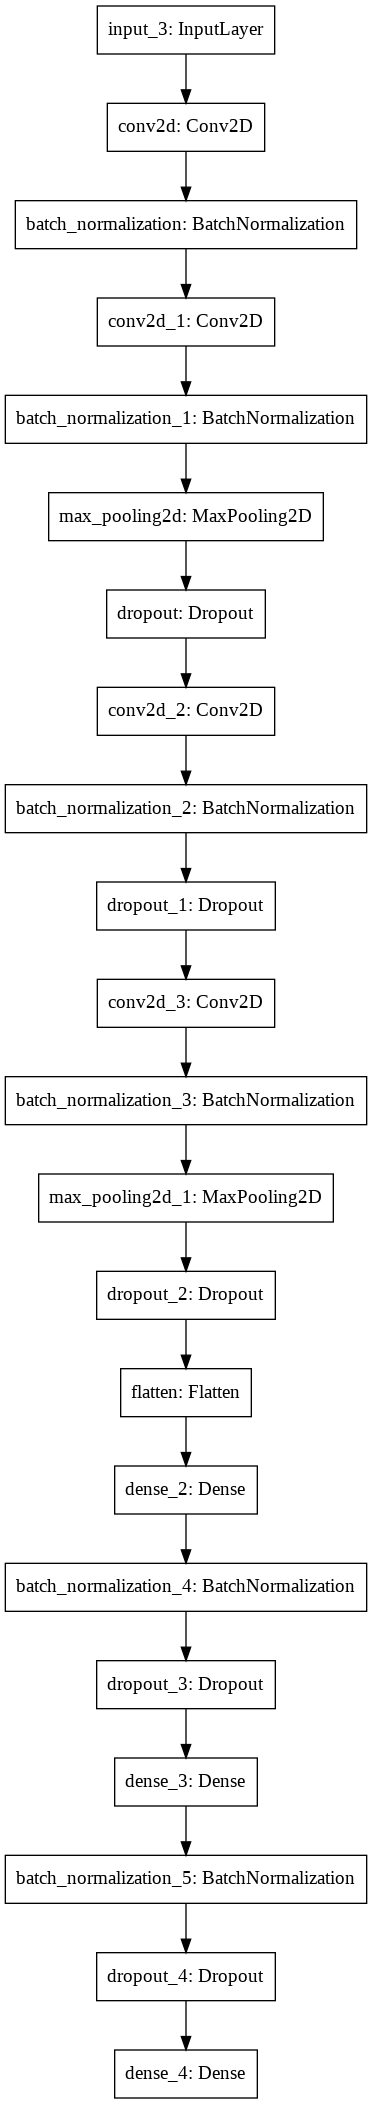

In [ ]:
keras.utils.plot_model(model2, "my_second_model.png")

*3) Fusion model*

In [ ]:
# model definition
inp3 = keras.Input(shape=(imageSize, imageSize, Channels))

# transfer learning model (VGG16)
x = vgg16(inp3, training=False)
x = GlobalMaxPool2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10,activation="softmax")(x)

# CNN with 4 layers
y = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp3)
y = BatchNormalization()(y)
y = keras.layers.Conv2D(32, (3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = keras.layers.MaxPooling2D((2, 2))(y)
y = keras.layers.Dropout(0.25)(y)
y = keras.layers.Conv2D(64, (3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = keras.layers.Dropout(0.25)(y)
y = keras.layers.Conv2D(128, (3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = keras.layers.MaxPooling2D((2, 2))(y)
y = keras.layers.Dropout(0.25)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(512, activation='relu')(y)
y = BatchNormalization()(y)
y = keras.layers.Dropout(0.5)(y)
y = keras.layers.Dense(128, activation='relu')(y)
y = BatchNormalization()(y)
y = keras.layers.Dropout(0.5)(y)
y = keras.layers.Dense(10, activation='softmax')(y)

# Model fusion & Score fusion
out3 = Average()([x, y])

model3 = Model(inp3, out3)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 46, 46, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 46, 46, 32)   128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 32)   9248        batch_normalization_6[0][0]      
____________________________________________________________________________________________

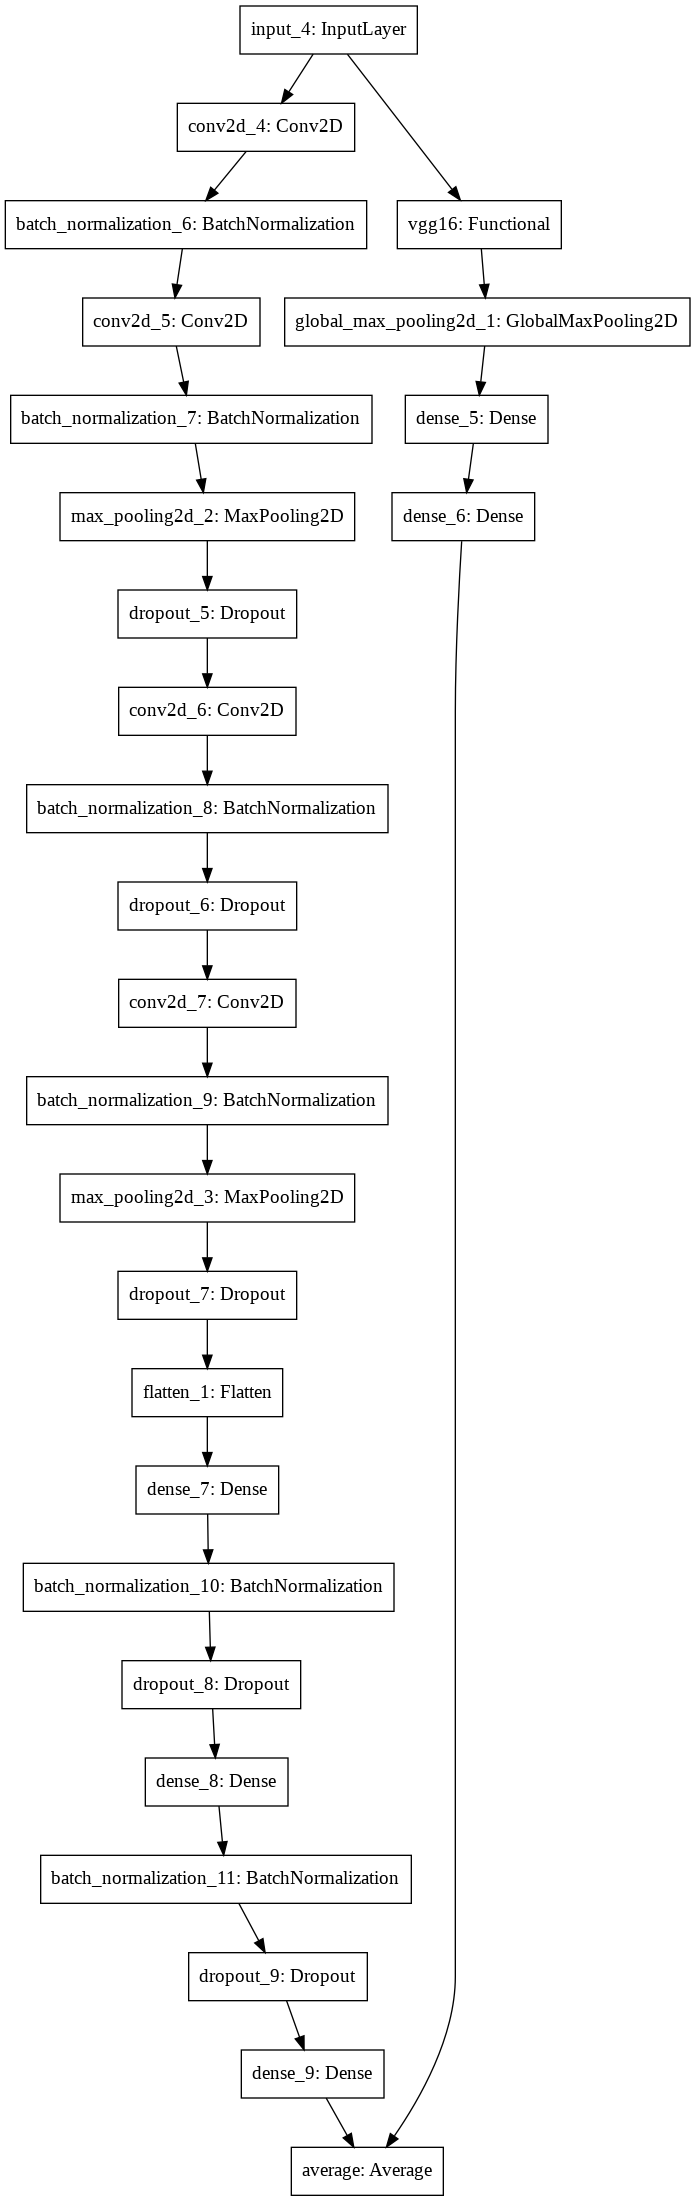

In [ ]:
keras.utils.plot_model(model3, "my_third_model.png")

*Compile model*

In [ ]:
# RMSPorp Optimization
optRMSProp=tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.0001, epsilon=1e-07, name="RMSprop",)

In [ ]:
# transfer learning model (VGG16)
model1.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

# CNN with 4 layers
model2.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

# fusion model
model3.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

*Train model*

In [ ]:
# hyperparameters 
Epochs = 100
BatchSize = 700

In [ ]:
# incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

*1) Uni-model (transfer learning model VGG16)*

In [ ]:
historyVgg16Model = model1.fit(trainX,train_label, validation_data=(validX,valid_label), epochs=Epochs 
                                                    , batch_size =BatchSize, verbose=1, callbacks=callbacks)

Epoch 1/100
82/82 [==============================] - 23s 171ms/step - loss: 2.2155 - accuracy: 0.2295 - val_loss: 1.6020 - val_accuracy: 0.6000
Epoch 2/100
82/82 [==============================] - 12s 151ms/step - loss: 1.4710 - accuracy: 0.6483 - val_loss: 1.1221 - val_accuracy: 0.7280
Epoch 3/100
82/82 [==============================] - 13s 153ms/step - loss: 1.0446 - accuracy: 0.7392 - val_loss: 0.8574 - val_accuracy: 0.7567
Epoch 4/100
82/82 [==============================] - 13s 154ms/step - loss: 0.8132 - accuracy: 0.7691 - val_loss: 0.7213 - val_accuracy: 0.7753
Epoch 5/100
82/82 [==============================] - 13s 158ms/step - loss: 0.6938 - accuracy: 0.7837 - val_loss: 0.6474 - val_accuracy: 0.7940
Epoch 6/100
82/82 [==============================] - 13s 161ms/step - loss: 0.6317 - accuracy: 0.7940 - val_loss: 0.5995 - val_accuracy: 0.7997
Epoch 7/100
82/82 [==============================] - 13s 161ms/step - loss: 0.5852 - accuracy: 0.8053 - val_loss: 0.5672 - val_accuracy:

In [ ]:
# save model
model1.save("WeightsForVgg16.h5")
print("Done for Vgg16")

Done for Vgg16


*2) Uni-model (CNN with 4 layers)*

In [ ]:
historyCNNModel = model2.fit(trainX,train_label, validation_data=(validX,valid_label), epochs=Epochs 
                                                    , batch_size =BatchSize, verbose=1, callbacks=callbacks)

Epoch 1/100
82/82 [==============================] - 19s 135ms/step - loss: 1.3862 - accuracy: 0.5745 - val_loss: 2.3170 - val_accuracy: 0.2857
Epoch 2/100
82/82 [==============================] - 11s 130ms/step - loss: 0.6698 - accuracy: 0.7681 - val_loss: 2.2206 - val_accuracy: 0.2330
Epoch 3/100
82/82 [==============================] - 11s 131ms/step - loss: 0.5469 - accuracy: 0.8083 - val_loss: 1.7375 - val_accuracy: 0.5213
Epoch 4/100
82/82 [==============================] - 11s 132ms/step - loss: 0.4767 - accuracy: 0.8330 - val_loss: 1.3883 - val_accuracy: 0.5873
Epoch 5/100
82/82 [==============================] - 11s 134ms/step - loss: 0.4416 - accuracy: 0.8450 - val_loss: 1.0213 - val_accuracy: 0.6493
Epoch 6/100
82/82 [==============================] - 11s 136ms/step - loss: 0.4043 - accuracy: 0.8577 - val_loss: 0.6065 - val_accuracy: 0.7793
Epoch 7/100
82/82 [==============================] - 11s 133ms/step - loss: 0.3757 - accuracy: 0.8682 - val_loss: 0.5902 - val_accuracy:

In [ ]:
# save model
model2.save("WeightsForCNN.h5")
print("Done for CNN")

Done for CNN


*3) Fusion model*

In [ ]:
historyFusionModel = model3.fit(trainX,train_label, validation_data=(validX,valid_label), epochs=Epochs 
                                                    , batch_size =BatchSize, verbose=1, callbacks=callbacks)

Epoch 1/100
82/82 [==============================] - 35s 293ms/step - loss: 1.3941 - accuracy: 0.5903 - val_loss: 2.0528 - val_accuracy: 0.1763
Epoch 2/100
82/82 [==============================] - 22s 269ms/step - loss: 0.8666 - accuracy: 0.7994 - val_loss: 1.6907 - val_accuracy: 0.5150
Epoch 3/100
82/82 [==============================] - 22s 274ms/step - loss: 0.7012 - accuracy: 0.8312 - val_loss: 1.3203 - val_accuracy: 0.6543
Epoch 4/100
82/82 [==============================] - 23s 279ms/step - loss: 0.5847 - accuracy: 0.8512 - val_loss: 0.9833 - val_accuracy: 0.6910
Epoch 5/100
82/82 [==============================] - 23s 276ms/step - loss: 0.5123 - accuracy: 0.8638 - val_loss: 0.6758 - val_accuracy: 0.7913
Epoch 6/100
82/82 [==============================] - 22s 274ms/step - loss: 0.4597 - accuracy: 0.8733 - val_loss: 0.5033 - val_accuracy: 0.8497
Epoch 7/100
82/82 [==============================] - 23s 277ms/step - loss: 0.4272 - accuracy: 0.8802 - val_loss: 0.4485 - val_accuracy:

In [ ]:
# save model
model3.save("WeightsForFusion.h5")
print("Done for Fusion")

Done for Fusion


***Visualizing Accuracy and loss***

*1) Uni-model (transfer learning model VGG16)*

- The Accuracy and Loss for Vgg16 Model


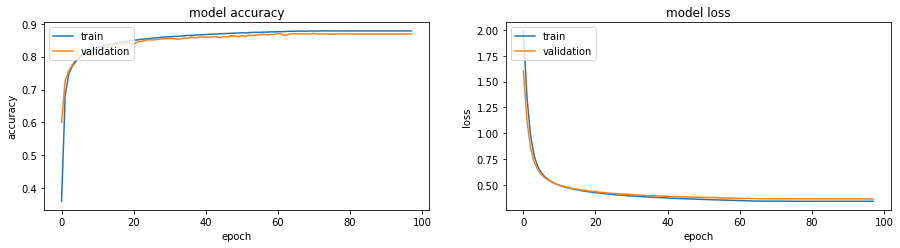

In [ ]:
#Vgg16 Model
print("- The Accuracy and Loss for Vgg16 Model")
plt.figure(figsize=(40,20))

# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyVgg16Model.history['accuracy'])
plt.plot(historyVgg16Model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyVgg16Model.history['loss'])
plt.plot(historyVgg16Model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

*2) Uni-model (CNN with 4 layers)*

- The Accuracy and Loss for CNN Model


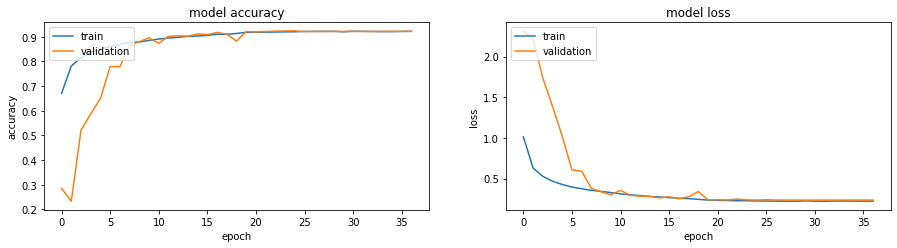

In [ ]:
#CNN Model
print("- The Accuracy and Loss for CNN Model")
plt.figure(figsize=(40,20))

# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyCNNModel.history['accuracy'])
plt.plot(historyCNNModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyCNNModel.history['loss'])
plt.plot(historyCNNModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

3) Fusion model

- The Accuracy and Loss for Fusion Model


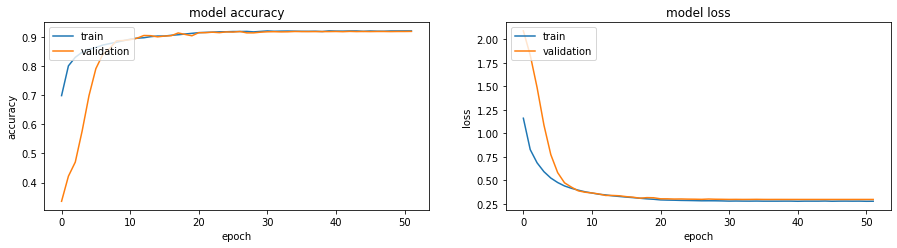

In [ ]:
#CNN Model
print("- The Accuracy and Loss for Fusion Model")
plt.figure(figsize=(40,20))

# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyFusionModel.history['accuracy'])
plt.plot(historyFusionModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyFusionModel.history['loss'])
plt.plot(historyFusionModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

***Evaluate Models***

In [ ]:
# VGG16 Model
print("Evaluate VGG16 Model")
model1.evaluate(testX,testY_one_hot)

Evaluate VGG16 Model
313/313 [==============================] - 4s 12ms/step - loss: 0.3499 - accuracy: 0.8746


[0.3499150276184082, 0.8745999932289124]

In [ ]:
# CNN Model
print("Evaluate CNN Model")
model2.evaluate(testX,testY_one_hot)

Evaluate CNN Model
313/313 [==============================] - 1s 4ms/step - loss: 0.2246 - accuracy: 0.9232


[0.22458283603191376, 0.9232000112533569]

In [ ]:
# Fusion Model
print("Evaluate Fusion Model")
model3.evaluate(testX,testY_one_hot)

Evaluate Fusion Model
313/313 [==============================] - 5s 14ms/step - loss: 0.2793 - accuracy: 0.9200


[0.2793245017528534, 0.9200000166893005]

***Predict models***

In [ ]:
# VGG16 Model
PredVgg16 = model1.predict(testX)
PredVgg16 = np.argmax(PredVgg16,axis=1)
print("\nPrediction values for Vgg16 Model :\n",PredVgg16)


Prediction values for Vgg16 Model :
 [0 1 2 ... 8 8 1]


In [ ]:
# CNN Model
PredCNN = model2.predict(testX)
PredCNN = np.argmax(PredCNN,axis=1)
print("\nPrediction values for Vgg16 Model :\n",PredCNN)


Prediction values for Vgg16 Model :
 [0 1 2 ... 8 8 1]


In [ ]:
# Fusion Model
PredFusion = model3.predict(testX)
PredFusion = np.argmax(PredFusion,axis=1)
print("\nPrediction values for Vgg16 Model :\n",PredFusion)


Prediction values for Vgg16 Model :
 [0 1 2 ... 8 8 1]


***Evaluate predictions***

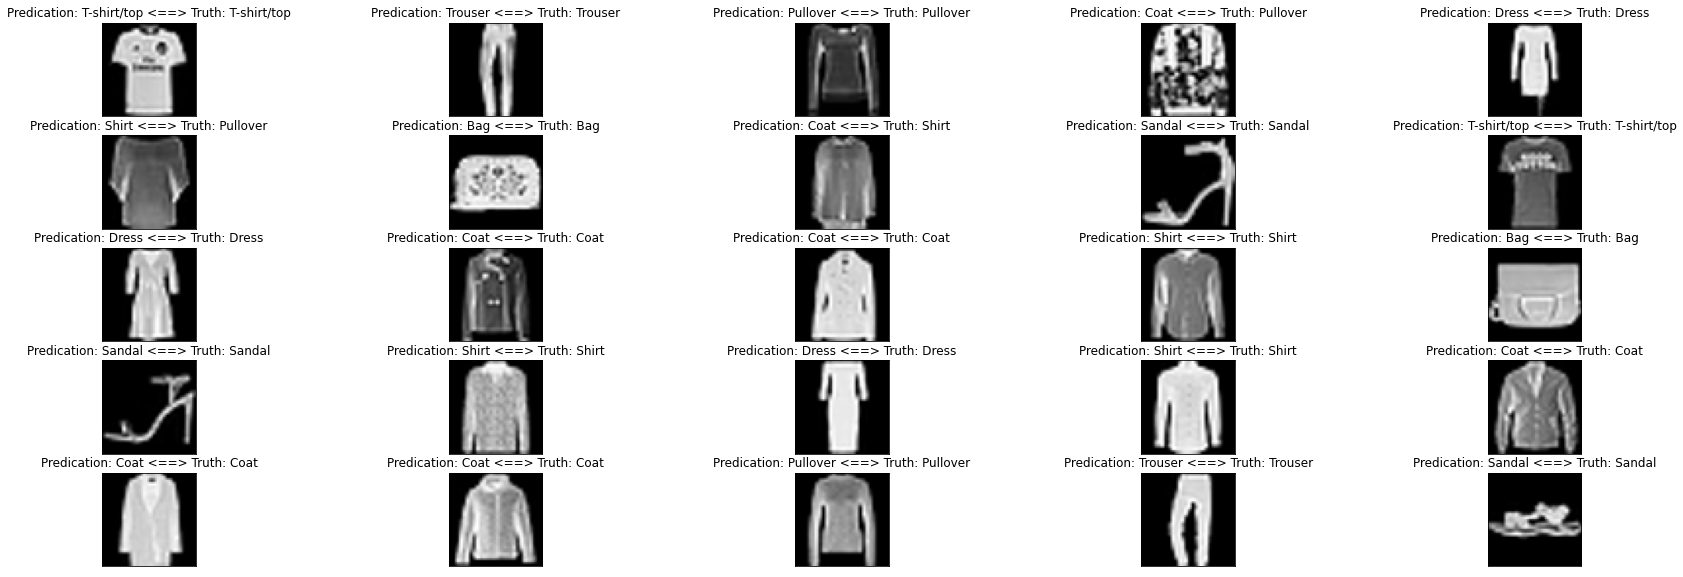

In [ ]:
# VGG16 model
plt.figure(figsize=(30,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(f"Predication: {class_name[PredVgg16[i]]} <==> Truth: {class_name[testY[i]]}")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(testX[i])
plt.show()

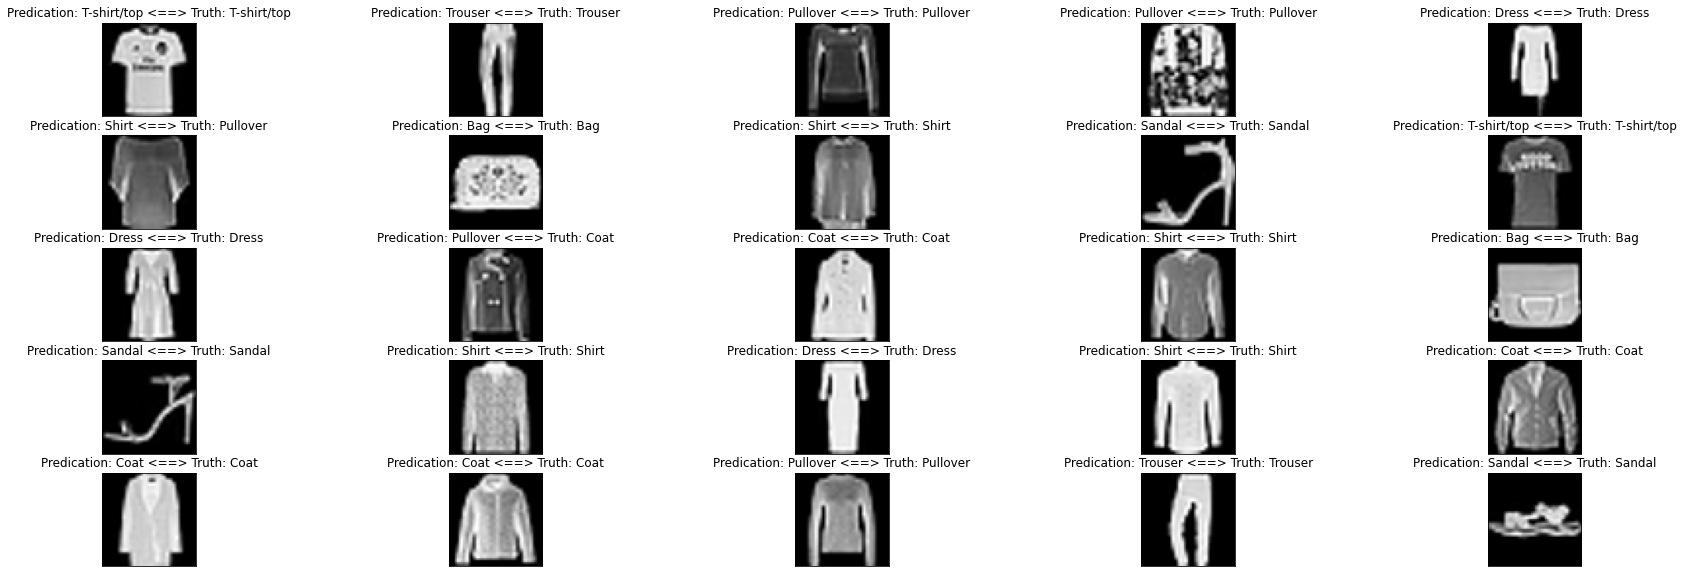

In [ ]:
# CNN model
plt.figure(figsize=(30,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(f"Predication: {class_name[PredCNN[i]]} <==> Truth: {class_name[testY[i]]}")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(testX[i])
plt.show()

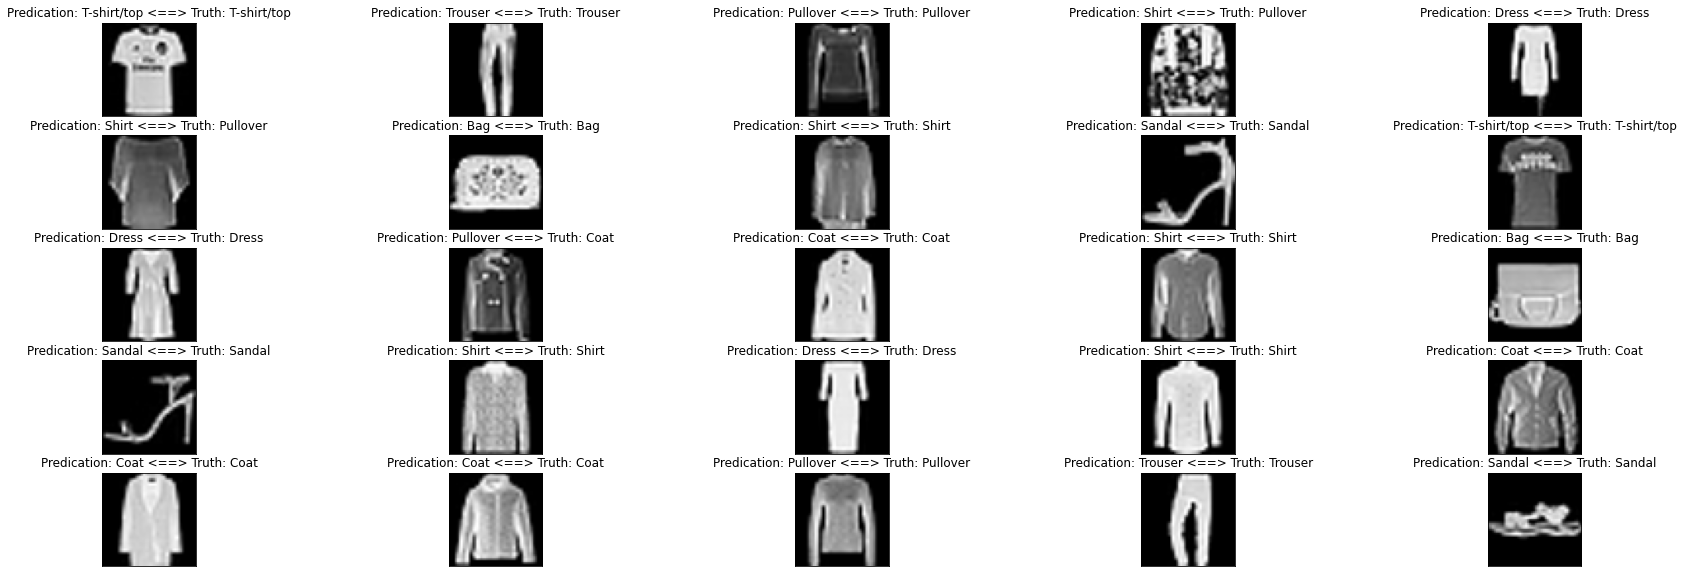

In [ ]:
# Fusion model
plt.figure(figsize=(30,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(f"Predication: {class_name[PredFusion[i]]} <==> Truth: {class_name[testY[i]]}")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(testX[i])
plt.show()

***Confusion Matrix***

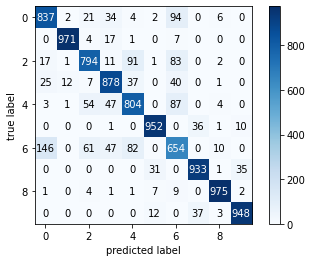

In [ ]:
# VGG16 Model
cm1 = confusion_matrix(testY,PredVgg16)
#print(cm1)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm1, colorbar=True)
plt.show()

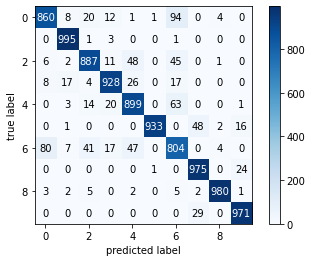

In [ ]:
# CNN Model
cm2 = confusion_matrix(testY,PredCNN)
#print(cm2)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm2, colorbar=True)
plt.show()

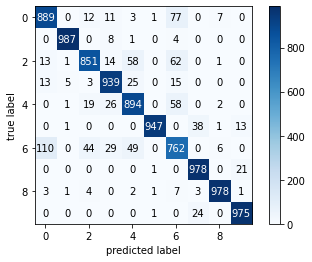

In [ ]:
# Fusion Model
cm3 = confusion_matrix(testY,PredFusion)
#print(cm3)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm3, colorbar=True)
plt.show()

***Classification Report***

In [ ]:
# VGG16 Model
ClassiReport1 = classification_report(testY,PredVgg16)
print('Classification Report for VGG16 Model is : \n ', ClassiReport1 )

Classification Report for VGG16 Model is : 
                precision    recall  f1-score   support

           0       0.81      0.84      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.84      0.79      0.82      1000
           3       0.85      0.88      0.86      1000
           4       0.79      0.80      0.80      1000
           5       0.95      0.95      0.95      1000
           6       0.67      0.65      0.66      1000
           7       0.93      0.93      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
# CNN Model
ClassiReport2 = classification_report(testY,PredCNN)
print('Classification Report for CNN Model is : \n ', ClassiReport2 )

Classification Report for CNN Model is : 
                precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.96      0.99      0.98      1000
           2       0.91      0.89      0.90      1000
           3       0.94      0.93      0.93      1000
           4       0.88      0.90      0.89      1000
           5       1.00      0.93      0.96      1000
           6       0.78      0.80      0.79      1000
           7       0.93      0.97      0.95      1000
           8       0.99      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
# VGG16 Model
ClassiReport3 = classification_report(testY,PredFusion)
print('Classification Report for VGG16 Model is : \n ', ClassiReport3 )

Classification Report for VGG16 Model is : 
                precision    recall  f1-score   support

           0       0.86      0.89      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.91      0.85      0.88      1000
           3       0.91      0.94      0.93      1000
           4       0.87      0.89      0.88      1000
           5       1.00      0.95      0.97      1000
           6       0.77      0.76      0.77      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



***t-SNE plot***

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
custom_palette = sns.color_palette("Paired", 10)
tsne = TSNE(learning_rate=200.0, n_iter=2000, perplexity=50.0)

*Testing data*

In [ ]:
tsnetest=tsne.fit_transform(tex)

In [ ]:
testdata['x'] = tsnetest[:,0]
testdata['y'] = tsnetest[:,1]


<function matplotlib.pyplot.show>

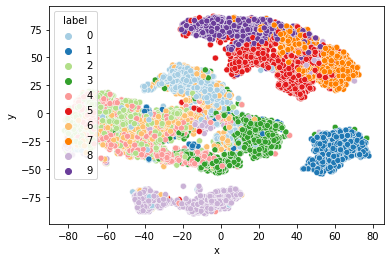

In [ ]:
sns.scatterplot(x='x', y ='y', hue=testdata['label'], data=testdata, palette=custom_palette)
plt.show

*After testing*

*1) VGG16*

In [ ]:
Vgg16List = []
for i in range(0,10000)
    Vgg16List.append([PredVgg16[i]])
Vgg16List = np.asarray(Vgg16List)
Vgg16List

In [ ]:
sns.scatterplot(x='c', y ='d', hue=Vgg16List, data=testdata, palette=custom_palette)
plt.show

*2) CNN*

In [ ]:
CNNList = []
for i in range(0,10000)
    CNNList.append([PredCNN[i]])
CNNList = np.asarray(CNNList)
CNNList

In [ ]:
sns.scatterplot(x='c', y ='d', hue=CNNList, data=testdata, palette=custom_palette)
plt.show

3) Fusion Model

In [ ]:
FusionList = []
for i in range(0,10000):
    FusionList.append(PredFusion[i])
FusionList = np.asarray(FusionList)
FusionList

array([0, 1, 2, ..., 8, 8, 1])

<function matplotlib.pyplot.show>

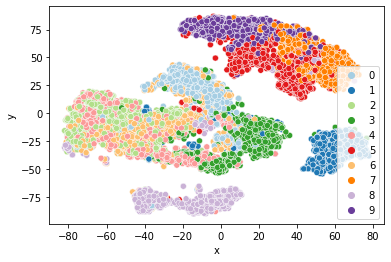

In [ ]:
sns.scatterplot(x='x', y ='y', hue=FusionList, data=testdata, palette=custom_palette)
plt.show